In [10]:
from ipynb.fs.full.feature_engineering_final import X_Transformer_scaled
from ipynb.fs.full.feature_engineering_final import TargetNormalizedRegressor
import pandas as pd
from lightgbm import LGBMRegressor
from ipynb.fs.full.feature_engineering_final import DataLoader
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import make_scorer
import numpy as np
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error
import numpy.ma as ma
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import skew
from scipy.stats import boxcox_normmax
from scipy.special import boxcox1p
import seaborn as sns

In [11]:
def rmsle(y_true, y_pred, sample_weight=None, multioutput='uniform_average'):
    return np.sqrt(mean_squared_log_error(y_true, y_pred, sample_weight, multioutput))
    
#I just want to make rmse positive
flipped_score = make_scorer(rmsle, greater_is_better=True)

In [12]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5),scoring=None):
   
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,scoring = scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [13]:
data_loader = DataLoader("train.csv","test.csv")

/home/victor/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/victor/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3429: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


In [14]:
X_train = data_loader.getX_train()
Y_train = data_loader.getY_train()

In [15]:
x_transformer = X_Transformer_scaled()

In [16]:
X_train = x_transformer.fit_transform(X_train,Y_train)
kf = KFold(n_splits=10,shuffle = True,random_state = 42)

Rmse log average: 0.10568 (+/- 0.03239)
Rmse log median: 0.10525
[0.12122335 0.11307834 0.08916978 0.1052259  0.10527921 0.11697652
 0.07213888 0.1031404  0.09780572 0.13273853]


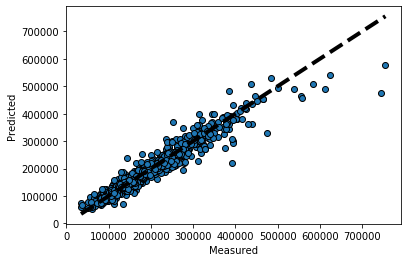

In [17]:
#cross validation and predicted vs measured cross validation
xgb_regressor_cross_val = TargetNormalizedRegressor(LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=1, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       ))
scores = cross_val_score(xgb_regressor_cross_val, X_train, Y_train, cv=kf,n_jobs=-1,scoring = flipped_score)
print("Rmse log average: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))
print("Rmse log median: %0.5f" % (np.median(scores)))
predicted = cross_val_predict(xgb_regressor_cross_val, X_train, Y_train, cv=kf,n_jobs=-1)
print(scores)
fig, ax = plt.subplots()
ax.scatter(Y_train, predicted, edgecolors=(0, 0, 0))
ax.plot([Y_train.min(), Y_train.max()], [Y_train.min(), Y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

<module 'matplotlib.pyplot' from '/home/victor/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

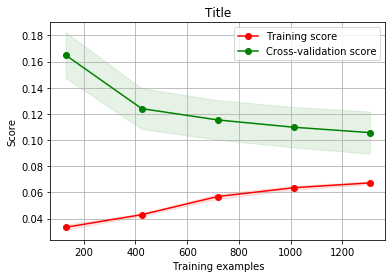

In [18]:
#learning curve of best model
plot_learning_curve(xgb_regressor_cross_val, "Title", X_train, Y_train, None, cv=kf, n_jobs=-1,scoring = flipped_score)